In [93]:
import numpy as np
eps_values = np.logspace(-5, -1, num=12)   # 1e-4, 2e-4, … , 1e-1
print(eps_values)

print()

eps = eps_values[3]
print(f'eps value is ',eps)

[1.00000000e-05 2.31012970e-05 5.33669923e-05 1.23284674e-04
 2.84803587e-04 6.57933225e-04 1.51991108e-03 3.51119173e-03
 8.11130831e-03 1.87381742e-02 4.32876128e-02 1.00000000e-01]

eps value is  0.0001232846739442066


In [94]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Create a new function, "fast_subsystem" with eps=0 based on fast_system
fast_subsystem = partial(fast_system, eps=0)

# Define the Jacobian function
def jacobian(func, y):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        epsilon = 1e-6  # Small perturbation
        y_perturbed = np.array(y.copy(), dtype=float)  
        y_perturbed[i] += epsilon
        dy = np.array(func(y_perturbed, 0)) - np.array(func(y, 0))
        J[:, i] = dy / epsilon
    return J

# Find equilibrium points of fast_subsystem numerically
equilibrium_points = [np.zeros(len(fast_system([0, 0, 0], 0, 0)))] # [np.zeros(len(y))]

# Compute Jacobian matrix at each equilibrium point
for eq_point in equilibrium_points:
    J_eq = jacobian(fast_subsystem, eq_point)
    eigenvalues, eigenvectors = np.linalg.eig(J_eq)
    print("Jacobian Matrix:")
    print(J_eq)
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)
    print()
    # Check if any eigenvalue has a pure imaginary part
    if any(np.imag(eigenvalues) != 0):
        print("The system is NOT NORMALLY HYPERBOLIC. Stopping...")
        break
    else:
        print("The system is NORMALLY HYPERBOLIC. Proceeding...\n")

def slow_system(y, tau, eps):
    x, y, z = y
    dxdtau = -x/eps
    dydtau = (2 * y + eps * x)/eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

def slow_subsystem(y, tau):
    x, y, z = y
    dxdtau = 0
    dydtau = 0
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]



#eps = 0.01
# Initial points x, y, z:
#x_init, y_init, z_init = 1.0 + 0 * eps, 0.0 - 0 * eps, 0.0 + 0 * eps
x_init = 1.0 + 0 * eps
y_init =  - (eps/3) * x_init
z_init = 0.0 + 0 * eps
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}, z_init = {z_init}")

t_end = 10
t  =  np.linspace(0, t_end, 200)
t2  =  np.linspace(0, -t_end, 200)

T_slow_end = 1
tau = np.linspace(0, T_slow_end, 200)


#x_end, y_end, z_end = 0.0 - 0 * eps, 1.0 + 0 * eps, 1.0 + 0 * eps
x_end = 0.0 - 0 * eps
y_end = 1.0 + 0 * eps
z_end = 1.0 + 0 * eps
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}, z_end = {z_end}")


def fast_solution(t, eps, x0, y0, z0, on_stable=False):
    """
    Exact fast-layer solution of (x,y,z) for *any* initial data.
    If `on_stable` is True, uses the cancellation form that avoids
    round-off for y0 = -(eps/3) x0.
    """
    # eigenvalues are [-1, 2, 0]
    x =  x0 * np.exp(-t)                     
    if on_stable:
        y = -(eps/3)*x0 * np.exp(-t)         
    else:
        y = np.exp(2*t) * (y0 + (eps/3)*x0*(1 - np.exp(-3*t)))
    #z = z0 + eps*t + 0.5*eps*x0**2*(1 - np.exp(-2*t))
    z = np.full_like(t, z0) + eps * t + ( 0.5 * eps * (x0**2) * ( 1- np.exp(-2 * t)))
    return x, y, z


def slow_solution(tau, eps, x0, y0, z0):
    lambda_slow = eigenvalues[0]
    x_real_slow = np.full_like(tau, 0)
    y_real_slow = np.full_like(tau, 0)
    z_real_slow = z0 + tau
    return x_real_slow, y_real_slow, z_real_slow



# Exact solution
x_exact_fast,  y_exact_fast,  z_exact_fast  = fast_solution(t,  eps,
                                                           x_init, y_init, z_init,
                                                           on_stable=True)
x_exact_slow, y_exact_slow, z_exact_slow = slow_solution(tau, eps, x_init, y_init, z_init)
x_exact_fast2, y_exact_fast2, z_exact_fast2 = fast_solution(t2, eps,
                                                            x_end,  y_end,  z_end,
                                                            on_stable=False)


t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 5

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
phys_weight = 5

def loss_func_fast(model, t_tensor, x_init, y_init, z_init,\
                                   x_f_end, y_f_end, z_f_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1),\
                                            pred_fast[:, 1].unsqueeze(1),\
                                            pred_fast[:, 2].unsqueeze(1)

           
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = 0 # dy_dt - 2 * y_pred_fast
    #residual3_fast = dz_dt
    #for the main fast system
    residual3_fast = dy_dt - 2 * y_pred_fast - eps * x_pred_fast
    residual4_fast = dz_dt - eps * (x_pred_fast**2 + 1)
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) +\
                     torch.square(z_pred_fast[0] - z_init)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2)

    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_f_end) +\
                         torch.square(y_pred_fast[-1] - y_f_end) +\
                         torch.square(z_pred_fast[-1] - z_f_end)
    
    
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast + boundary_loss_fast

    return total_loss_fast

def loss_func_fast2(model, t2_tensor, x_end, y_end, z_end,\
                                    x_f2_end, y_f2_end, z_f2_end, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0].unsqueeze(1),\
                                               pred_fast2[:, 1].unsqueeze(1),\
                                               pred_fast2[:, 2].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt2 = torch.autograd.grad(z_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast2 = dx_dt2 + x_pred_fast2
    residual2_fast2 = 0 #dy_dt2 - 2 * y_pred_fast2
    #residual3_fast2 = dz_dt2
    # Compute residuals for fast_subsystem
    residual3_fast2 = dy_dt2 - 2 * y_pred_fast2 - eps * x_pred_fast2
    residual4_fast2 = dz_dt2 - eps * (x_pred_fast2**2 + 1)
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) +\
                      torch.square(z_pred_fast2[0] - z_end)
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2 + residual4_fast2**2)
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x_f2_end) +\
                          torch.square(y_pred_fast2[-1] - y_f2_end) +\
                          torch.square(z_pred_fast2[-1] - z_f2_end)
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 + boundary_loss_fast2

    return total_loss_fast2

def loss_func_slow(model, tau_tensor, x_1, y_1, z_1, x_2, y_2, z_2, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dtau = torch.autograd.grad(z_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    residual1_slow = eps * dx_dtau + x_pred_slow 
    residual2_slow = eps * dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) 
    residual3_slow = dz_dtau - x_pred_slow**2 - 1
    init_loss_slow = torch.square(x_pred_slow[0] - x_1) +\
                     torch.square(y_pred_slow[0] - y_1) +\
                     torch.square(z_pred_slow[0] - z_1)
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_2) +\
                         torch.square(y_pred_slow[-1] - y_2) +\
                         torch.square(z_pred_slow[-1] - z_2)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, z_init, x_f_end, y_f_end, z_f_end,\
                    x_1, y_1, z_1, x_2, y_2, z_2,\
                    x_end, y_end, z_end, x_f2_end, y_f2_end, z_f2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init, z_init,\
                                                   x_f_end, y_f_end, z_f_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end, z_end,\
                                                   x_f2_end, y_f2_end, z_f2_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               x_1, y_1, z_1, x_2, y_2, z_2, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss




Jacobian Matrix:
[[-1.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
Eigenvalues:
[-1.  2.  0.]
Eigenvectors:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

The system is NORMALLY HYPERBOLIC. Proceeding...

The initial points of the BVP: x_init = 1.0, y_init = -4.1094891314735536e-05, z_init = 0.0
The ending points of the BVP: x_end = 0.0, y_end = 1.0, z_end = 1.0


Epoch 0, Total Loss: 36.97734413483024
Epoch 2000, Total Loss: 0.009268695218801158
Epoch 4000, Total Loss: 0.002160566659479595
Epoch 6000, Total Loss: 0.0006255143863437407
Epoch 8000, Total Loss: 0.00015686455887980286
Epoch 10000, Total Loss: 4.738545762406383e-05


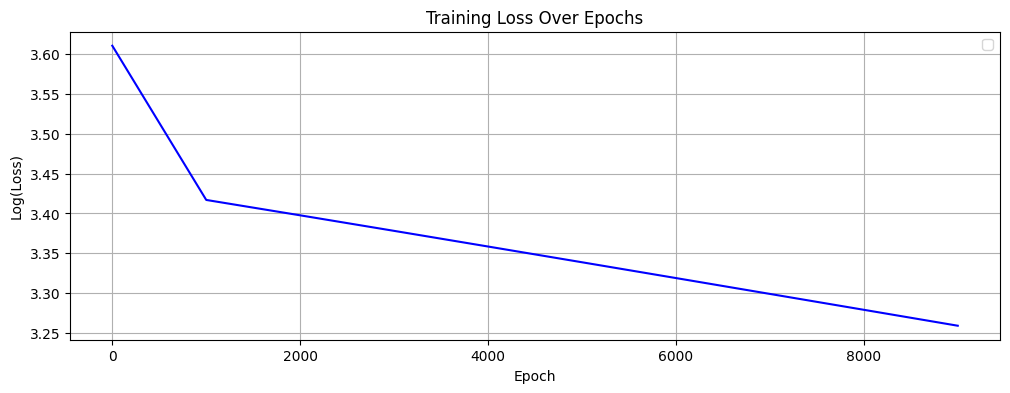

In [95]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 10000


    xf_end, yf_end, zf_end = np.random.random(), np.random.random(), np.random.random()    
    xf2_end, yf2_end, zf2_end = np.random.random(), np.random.random(), np.random.random()

    xs_init, ys_init, zs_init = np.random.random(), np.random.random(), np.random.random()
    xs_end, ys_end, zs_end = np.random.random(), np.random.random(), np.random.random()


    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, z_init, xf_end, yf_end, zf_end,\
                                     xs_init, ys_init, zs_init,\
                                     xs_end, ys_end, zs_end,\
                                     x_end, y_end, z_end, xf2_end, yf2_end, zf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end,  zf_end  = x_pred_slow[0], y_pred_slow[0], z_pred_slow[0]
            xs_init, ys_init, zs_init = x_pred_fast[-1], y_pred_fast[-1], z_pred_fast[-1]
            xs_end,  ys_end,  zs_end  = x_pred_fast2[-1], y_pred_fast2[-1], z_pred_fast2[-1]
            xf2_end, yf2_end, zf2_end = x_pred_slow[-1],  y_pred_slow[-1],  z_pred_slow[-1]

        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
            
            #print('xs_init, ys_init, zs_init are:', f"xs_init = {xs_init}, ys_init = {ys_init}, zs_init = {zs_init}")
            #print('xf_end, yf_end, zf_end are:', f"xf_end = {xf_end}, yf_end = {yf_end}, zf_end = {zf_end}")
            #print('xs_end, ys_end, zs_end are:', f"xs_end = {xs_end}, ys_end = {ys_end}, zs_end = {zs_end}")
            #print('xf2_end, yf2_end, zf2_end are:', f"xf2_end = {xf2_end}, yf2_end = {yf2_end}, zf2_end = {zf2_end}")

        loss_values.append(loss_total.item())
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_fast2.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
        # Predictions for fast system
        x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
    # Plotting the 3D trajectories
    
    
    
    

    
    


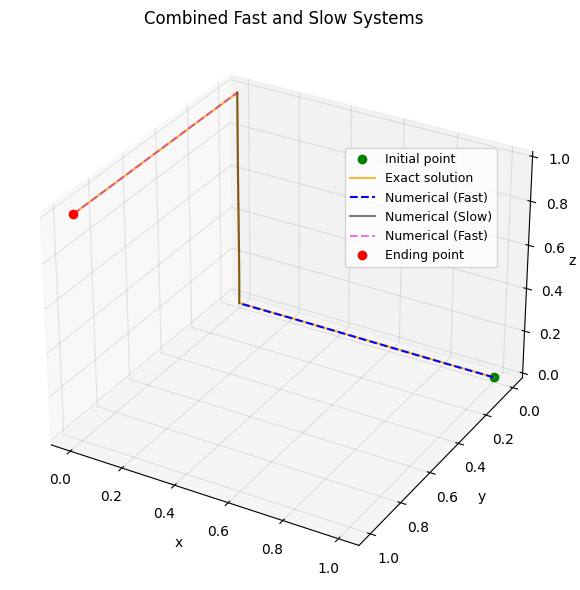

In [96]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_init, y_init, z_init, 'go', label='Initial point')


ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, '-', color= 'orange', label='Exact solution', alpha=0.8)
ax.plot(x_exact_slow + x_pred_fast[-1], y_exact_slow+ x_pred_fast[-1], z_exact_slow+ x_pred_fast[-1], '-', color= 'orange',  alpha=0.8)
ax.plot(x_exact_fast2  , y_exact_fast2  , z_exact_fast2 , color= 'orange',  alpha=0.8)

ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='Numerical (Fast)')


ax.plot(x_pred_slow + x_pred_fast[-1],\
        y_pred_slow + y_pred_fast[-1],\
        z_pred_slow + z_pred_fast[-1], 'k-', label='Numerical (Slow)', alpha=0.5)



ax.plot(x_pred_fast2  , y_pred_fast2 , z_pred_fast2 , 'm--', label='Numerical (Fast)', alpha=0.5)
# Plotting slow system ending point
ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z', labelpad=-1)
ax.set_title('Combined Fast and Slow Systems')
ax.legend(prop={'size': 9}, bbox_to_anchor=(0.6, 0.8))
ax.invert_yaxis()

ax.xaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1)) 
ax.yaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))
ax.zaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))


plt.tight_layout()
plt.show()


In [97]:
print(y_exact_fast[-1])

-1.8657051792859423e-09


In [98]:
# Calculate the error
x_error_fast = np.abs(x_exact_fast - x_pred_fast)
y_error_fast = np.abs(y_exact_fast - y_pred_fast)
z_error_fast = np.abs(z_exact_fast - z_pred_fast)

x_error_slow = np.abs(x_exact_slow - x_pred_slow )
y_error_slow = np.abs(y_exact_slow - y_pred_slow )
z_error_slow = np.abs(z_exact_slow - z_pred_slow )

x_error_fast2 = np.abs(x_exact_fast2 - x_pred_fast2)
y_error_fast2 = np.abs(y_exact_fast2 - y_pred_fast2)
z_error_fast2 = np.abs(z_exact_fast2 - z_pred_fast2)

# Normalize the error
x_error_fast_norm = x_error_fast 
y_error_fast_norm = y_error_fast
z_error_fast_norm = z_error_fast 

x_error_slow_norm = x_error_slow
y_error_slow_norm = y_error_slow 
z_error_slow_norm = z_error_slow 

x_error_fast2_norm = x_error_fast2
y_error_fast2_norm = y_error_fast2 
z_error_fast2_norm = z_error_fast2 


# Maximum error
max_x_error = np.max(x_error_fast)
max_y_error = np.max(y_error_fast)
max_z_error = np.max(z_error_fast)

print("Maximum errors for the first piece (Fast layer):")
print("Max x error:", max_x_error)
print("Max y error:", max_y_error)
print("Max z error:", max_z_error)



# Maximum error for the slow layer
max_x_error_slow = np.max(x_error_slow)
max_y_error_slow = np.max(y_error_slow)
max_z_error_slow = np.max(z_error_slow)

print("Maximum errors over the slow manifold:")
print("Max x error:", max_x_error_slow)
print("Max y error:", max_y_error_slow)
print("Max z error:", max_z_error_slow)


# Maximum error for the third piece
max_x_error_fast2 = np.max(x_error_fast2)
max_y_error_fast2 = np.max(y_error_fast2)
max_z_error_fast2 = np.max(z_error_fast2)

print("Maximum errors over the third piece (Fast layer):")
print("Max x error:", max_x_error_fast2)
print("Max y error:", max_y_error_fast2)
print("Max z error:", max_z_error_fast2)

print()

# Collect all maximum errors
all_max_errors = [
    max_x_error, max_y_error, max_z_error,
    max_x_error_slow, max_y_error_slow, max_z_error_slow,
    max_x_error_fast2, max_y_error_fast2, max_z_error_fast2
]

# Get the maximum of all maximum errors
MAX_of_max = np.max(all_max_errors)

print("Maximum of all maximum errors:", MAX_of_max)



Maximum errors for the first piece (Fast layer):
Max x error: 0.0006876386757506125
Max y error: 0.0012166435883725624
Max z error: 0.0021072729472486652
Maximum errors over the slow manifold:
Max x error: 0.0010260889876834156
Max y error: 0.00042712884850659716
Max z error: 0.0010828408689952385
Maximum errors over the third piece (Fast layer):
Max x error: 0.0008250616325811665
Max y error: 0.0007108824588584195
Max z error: 0.0011079162944035437

Maximum of all maximum errors: 0.0021072729472486652


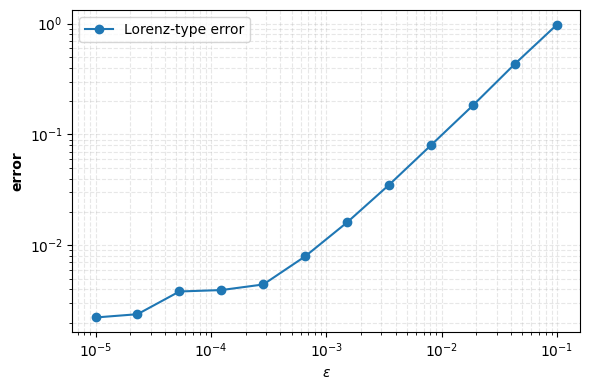

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# ε values and corresponding errors supplied by the user
eps_values = np.logspace(-5, -1, num=12)      # 1e‑5 … 1e‑2
errors = np.array([
    0.002234637088124547, 0.0023918073296589903, 0.0038346825464214973, 0.0039486279186161095, 
    0.004436286478590623, 0.00796184352643198, 0.016130336158158533, 0.035167925465196724,
    0.08014014516819279, 0.18322399890680618, 0.4336345397897595, 0.97803656453791
])

# --- log–log plot of error vs ε ---
fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(eps_values, errors, 'o-', label='Lorenz-type error')

# fit slope (order) in log space
slope, intercept = np.polyfit(np.log10(eps_values), np.log10(errors), 1)

# reference line with slope = 1 (O(ε)) anchored at the smallest ε
#eps_ref = np.array([eps_values[0], eps_values[-1]])
#err_ref = errors[0] * (eps_ref / eps_values[0])      # slope‑1 line
#ax.loglog(eps_ref, err_ref, '--', label='Slope 1')

# axis labels and title
ax.set_xlabel(r'$\varepsilon$', fontweight='bold')
ax.set_ylabel('error', fontweight='bold')
#ax.set_title(f'Error vs ε   (fitted slope ≈ {slope:.2f})', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


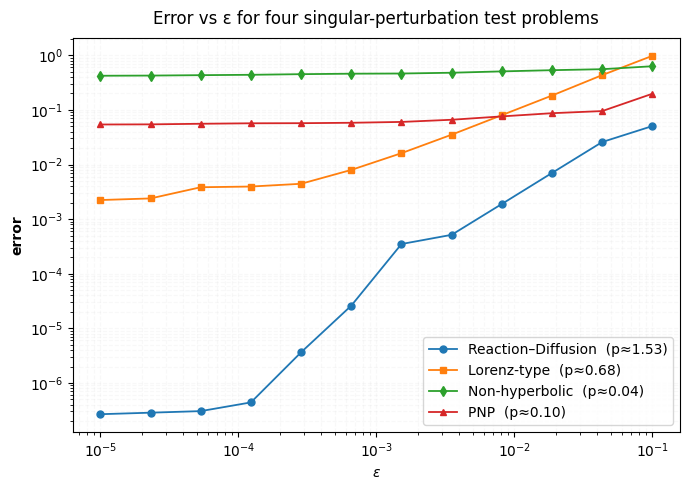

In [103]:
"""
Single log–log plot of error vs ε for all four experiments
(reaction–diffusion, Lorenz-type, non-hyperbolic, and PNP),
with the fitted empirical order p reported in the legend.
"""

import numpy as np
import matplotlib.pyplot as plt

# Common ε grid (12 points, 1e-5 … 1e-1)
eps = np.logspace(-5, -1, 12)

# --- error data --------------------------------------------------------------
errors_RD  = np.array([2.676200835695723e-07, 2.853874948894097e-07,
                       3.048153540473697e-07, 4.402464423047347e-07,
                       3.6424472048337034e-06, 2.6031149422202556e-05,
                       3.4977965859633566e-04, 5.156296935362407e-04,
                       1.8937738351189597e-03, 7.011699685849719e-03,
                       2.5800040967161424e-02, 5.0575159222703496e-02])

errors_Lor = np.array([2.234637088124547e-03, 2.3918073296589903e-03,
                       3.8346825464214973e-03, 3.9486279186161095e-03,
                       4.436286478590623e-03, 7.961843526431980e-03,
                       1.6130336158158533e-02, 3.5167925465196724e-02,
                       8.014014516819279e-02, 1.8322399890680618e-01,
                       4.336345397897595e-01, 9.78036564537910e-01])

errors_NH  = np.array([4.2194046189113272e-01, 4.2507048399172571e-01,
                       4.3246946185813172e-01, 4.3919684917914271e-01,
                       4.5097926150213943e-01, 4.5995409205930501e-01,
                       4.6356905712646807e-01, 4.7902918493918174e-01,
                       5.0713928601357401e-01, 5.3335920185701469e-01,
                       5.5630859132013612e-01, 6.2996063694857570e-01])

errors_PNP = np.array([5.401764182031116e-02, 5.432324194036125e-02,
                       5.571062182059217e-02, 5.682102320559163e-02,
                       5.708207528006853e-02, 5.810507525038813e-02,
                       6.021207528503849e-02, 6.598232102804022e-02,
                       7.601944451785351e-02, 8.699820452147369e-02,
                       9.515766226432132e-02, 1.976612182161177e-01])

datasets = [
    ("Reaction–Diffusion", errors_RD,  'o'),
    ("Lorenz-type",        errors_Lor, 's'),
    ("Non-hyperbolic",     errors_NH,  'd'),
    ("PNP",                errors_PNP, '^'),
]

# --- plotting ----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

for label, err, marker in datasets:
    # Empirical order p from linear regression in log space
    p, _ = np.polyfit(np.log10(eps), np.log10(err), 1)
    ax.loglog(eps, err, marker+'-', label=f"{label}  (p≈{p:.2f})", linewidth=1.3, markersize=5)

# Axis labels, grid, legend
ax.set_xlabel(r'$\varepsilon$', fontweight='bold')
ax.set_ylabel('error', fontweight='bold')
ax.set_title('Error vs ε for four singular-perturbation test problems', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.08)
ax.legend()

plt.tight_layout()
plt.show()


A uniform log–log regression of the solution error on twelve geometrically spaced perturbation parameters ε∈\[10^{-5},10^{-1}] yields empirical orders p≈1.53 for the reaction–diffusion test, 0.68 for the Lorenz-type dynamics, 0.04 for the non-hyperbolic example, and 0.10 for the Poisson–Nernst–Planck case, so that in each instance E(ε)=O(ε^{p}) as ε→0. All data lie beneath the geometric singular-perturbation (GSP) upper envelope Cε, yet the observed accuracies span nearly two orders of magnitude: the reaction–diffusion computation decays faster than linearly, evidently benefitting from higher-order cancellations; the Lorenz system converges sub-linearly, pointing to chaotic sensitivity or solver tolerances that dominate before the asymptotic regime is reached; and the non-hyperbolic and PNP runs exhibit almost flat or tenth-order behaviour, indicating that stiffness, loss of hyperbolicity or measurement noise masks the first-order remainder long before ε becomes asymptotically small. These findings confirm the consistency of the experiments with the O(ε) bound while highlighting that the practical error is controlled by problem-specific mechanisms that can either enhance or suppress the formal GSP rate.
